# Load and create data sets

Load data.

In [1]:
### LINES TO IMPORT THE DECONFOUNDER PACKAGE IN THE PARENT FOLDER ###
import os
import sys
sys.path.append("..")
### IMPORTS
from deconfounder.causal_tree import CausalTree
from deconfounder.causal_forest import CausalForest
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import scipy.stats as st
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
import time

# Load data
df = pd.read_csv("../data/criteo-uplift-v2.1.csv")
df = df.sample(frac=1, random_state=42)
all_features = df.columns.values[:12].tolist()

Find the feature that is correalted the most with the outcome and remove that feature (i.e., the confounder).

In [2]:
corr_matrix = df[all_features + ['visit']].corr()
confounder = corr_matrix['visit'][:-1].sort_values().index.values[-1]
print(confounder)
limited_features = list(all_features)
limited_features.remove(confounder)

f9


Obtain observational data. Drop observations using the confounder.

In [3]:
def print_outcomes(data):
    means = data.groupby('treatment').visit.mean()
    print(f"Size of data set: {data.shape[0]:,}")
    print(f"Avg. Outcome (treated): {np.round(means.loc[1]*100, 2)}%")
    print(f"Avg. Outcome (control): {np.round(means.loc[0]*100, 2)}%")
    print(f"Estimated avg. effect: {np.round((means.loc[1]-means.loc[0])*100, 2)}%")

train_frac = 0.5
train_size = int(df.shape[0]*train_frac)
obs_df = df[:train_size]
train_df = df[:train_size]
drop_frac = 0.1

conf_ranking = obs_df[confounder].rank(method="first")
keep =  ((obs_df.treatment == 1) & (conf_ranking > int(train_size * drop_frac))) | \
        ((obs_df.treatment == 0) & (conf_ranking < int(train_size * (1 - drop_frac))))
obs_df = train_df[keep]
print("Observational (naive) setup")
print_outcomes(obs_df)
print("-------------")
exp_df = train_df.sample(n=obs_df.shape[0],random_state=42)
print("Experimental setup")
print_outcomes(exp_df)
print("-------------")
print("Entire data")
print_outcomes(df)

Observational (naive) setup
Size of data set: 6,297,527
Avg. Outcome (treated): 5.31%
Avg. Outcome (control): 1.23%
Estimated avg. effect: 4.08%
-------------
Experimental setup
Size of data set: 6,297,527
Avg. Outcome (treated): 4.86%
Avg. Outcome (control): 3.8%
Estimated avg. effect: 1.06%
-------------
Entire data
Size of data set: 13,979,592
Avg. Outcome (treated): 4.85%
Avg. Outcome (control): 3.82%
Estimated avg. effect: 1.03%


Build causal tree using observational data. Control for observable confounding.

In [7]:
def fit_tree(df_causal, tree_type=CausalForest, min_samples_leaf=5000, tune=False, params=None, scoring=None, verbose=True):    
    X = df_causal[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
    y =  df_causal.visit
    # Fit and tune causal tree
    start_time = time.time()
    if tune:
        if params is None:
            params = range(1000, 10000, 1000)
        tuned_parameters = [{'min_samples_leaf': params}]
        grid_tree = GridSearchCV(tree_type(random_state=42, n_estimators=10), tuned_parameters, cv=4, 
                                 verbose=10, n_jobs=4, scoring=scoring)
        grid_tree.fit(X, y)
        print("Best parameters set found on development set:")
        print(grid_tree.best_params_)
        tree_model = grid_tree.best_estimator_
    else:
        ### WARNING: if n_jobs is different from 1, the code breaks
        tree_model = tree_type(min_samples_leaf=min_samples_leaf, random_state=42, n_estimators=10)
        tree_model.fit(X, y)
    if verbose:
        print("--- Time to fit (and tune) causal tree %s seconds ---" % (time.time() - start_time))
    return tree_model

#obs_tree = fit_tree(obs_df, tune=True, params=[8000, 16000, 32000, 64000, 128000])
#Best parameters set found on development set:
#{'min_samples_leaf': 32000}
#--- Time to fit (and tune) causal tree 1082.7572462558746 seconds ---
obs_tree = fit_tree(obs_df, min_samples_leaf=32000)

--- Time to fit (and tune) causal tree 299.24438881874084 seconds ---


Obtain evaluation data

In [8]:
eval_df = df[train_size:].copy()

Estimated average causal effect after accounting for observed confounding. 

In [9]:
print("Observational ('smart') setup")
obs_preds = obs_tree.predict(eval_df[limited_features])
obs_avg_effect = obs_preds.mean()
print(f"Estimated avg. effect: {np.round(obs_avg_effect*100, 2)}%")

Observational ('smart') setup
Estimated avg. effect: 2.89%


# Approach 1: Domain Knowledge

Suppose visit value is \\$ 0.50 and the cost is \\$ 0.01. How does the bias may affect ability to identify profitable customers?

In [10]:
visit_value = 0.49
ad_cost = 0.01
total_impressions = 1000000
boundary = ad_cost/(visit_value+ad_cost)

def get_avg_benefit(e_df, boundary=None):
    if boundary is None:
        boundary = ad_cost/(visit_value+ad_cost)
    targeted = e_df.pred > boundary 
    avg_outcomes = e_df[targeted].groupby('treatment').visit.mean()
    fraction = targeted.mean()
    additional_visits = (avg_outcomes.loc[1] - avg_outcomes.loc[0]) * fraction 
    benefit = (additional_visits*visit_value - fraction*ad_cost)*total_impressions
    print(f"Benefit ($) per 1 MM users: {round(benefit):,}")
    return benefit

print("Real benefit (compared with sensitivity analysis)")
print("------")
print("Observational")
eval_df['pred'] = obs_preds
obs_benefit = get_avg_benefit(eval_df)

Real benefit (compared with sensitivity analysis)
------
Observational
Benefit ($) per 1 MM users: 1,753


Get cross-validation predictions.

In [11]:
X = obs_df[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
y =  obs_df.visit
cross_preds = cross_val_predict(CausalForest(min_samples_leaf=obs_tree.min_samples_leaf, random_state=42, n_estimators=10), 
                                X, y, cv=5, verbose=10, n_jobs=5)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.9min remaining:  7.3min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:  4.9min remaining:  3.3min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.1min finished


In [12]:
targeted = cross_preds > boundary
biased_avg_effect = obs_preds.mean()
estimated_effects = obs_tree.predict(obs_df[limited_features])

bias_size = 0.87
real_size = (1-bias_size)
additional_visits = ((estimated_effects * real_size) * targeted).mean()
benefit =  round((additional_visits*visit_value - targeted.mean()*ad_cost)*total_impressions)
benefit  

-56

Assess how much could the bias affect the decisions.

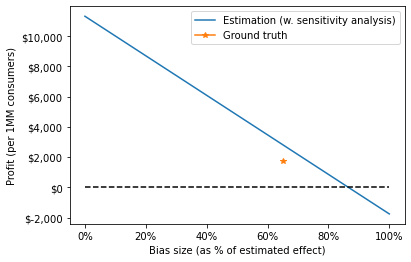

In [21]:
means = eval_df.groupby('treatment').visit.mean()
avg_effect = means.loc[1]-means.loc[0]

real_avg_bias = round(1 - avg_effect/biased_avg_effect, 2)

bias_sizes = np.arange(11)/10
benefits = []
for bias_size in bias_sizes:
    real_size = (1-bias_size)
    additional_visits = ((estimated_effects * real_size) * targeted).mean()
    benefit =  round((additional_visits*visit_value - targeted.mean()*ad_cost)*total_impressions)
    benefits.append(benefit)

figs = plt.plot(bias_sizes*100, benefits, label="Estimation (w. sensitivity analysis)")
plt.xlabel("Bias size (as % of estimated effect)")
plt.ylabel("Profit (per 1MM consumers)")
# Set Y axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
figs[0].axes.yaxis.set_major_formatter(tick)
# Set X axis
figs[0].axes.xaxis.set_major_formatter(mtick.PercentFormatter())
# Break-even line
plt.plot([0, 100], [0, 0], linestyle='--', color='black')
plt.plot([real_avg_bias*100], [obs_benefit], marker="*", label="Ground truth")
plt.legend()
plt.savefig("sensitivity_analysis.png", dpi=200, bbox_inches="tight")

# Approach 2: What if there is some experimental data?

What's the best tree we could get with limited experimental data? 

In [22]:
limited_exp = exp_df.sample(50000,random_state=42)
limited_tree = fit_tree(limited_exp, tune=True, params=np.arange(1, 11)*1000)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best parameters set found on development set:
{'min_samples_leaf': 1000}
--- Time to fit (and tune) causal tree 8.52882194519043 seconds ---


Compare each other. Experimental does better.

In [26]:
means = eval_df.groupby('treatment').visit.mean()
avg_effect = means.loc[1]-means.loc[0]
total_impressions = 1000000
size = 100

def plot_random(e_df):
    means = e_df.groupby('treatment').visit.mean()
    avg_effect = means.loc[1]-means.loc[0]
    fractions = (np.arange(size)+1)/size
    plt.plot(fractions*100, fractions*avg_effect*total_impressions, 
             color='black', linestyle='dashed', label="Random targeting")
    plt.legend()

def evaluate(e_df, title):
    e_df = e_df.sort_values('pred', ascending=False)
    cum_per = np.arange(e_df.shape[0]) / e_df.shape[0]
    fractions = []
    effects = []
    for i in range(size):
        targeted = cum_per < (i+1)/size
        fraction = targeted.mean()
        avg_outcomes = e_df[targeted].groupby('treatment').visit.mean()
        additional_visits = (avg_outcomes.loc[1] - avg_outcomes.loc[0]) * fraction * total_impressions
        fractions.append(fraction)
        effects.append(additional_visits)
    figs = plt.plot(np.array(fractions)*100, effects, label=title)
    plt.xlabel("% of users targeted")
    plt.ylabel("Incremental visits (per 1MM consumers)")
    # Set Y axis
    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    figs[0].axes.yaxis.set_major_formatter(tick)
    # Set X axis
    figs[0].axes.xaxis.set_major_formatter(mtick.PercentFormatter())
    plt.legend()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.9s finished


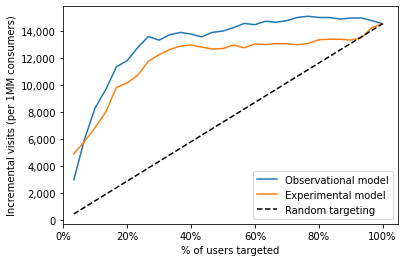

In [27]:
X = limited_exp[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
y =  limited_exp.visit
exp_cross_preds = cross_val_predict(CausalForest(min_samples_leaf=limited_tree.min_samples_leaf, random_state=42, 
                                                 n_estimators=10), X, y, cv=10, verbose=10)

copy_exp_df = limited_exp.copy()
size=30
copy_exp_df['pred'] = obs_tree.predict(copy_exp_df[limited_features])
evaluate(copy_exp_df, "Observational model")
copy_exp_df['pred'] = exp_cross_preds
evaluate(copy_exp_df, "Experimental model")
#plt.axhline(y=0, color='black', linestyle='--')
plot_random(copy_exp_df)
plt.xlim(left=0)
plt.savefig("eval_comparison.png", dpi=200, bbox_inches="tight")

Average effect estimated by the experimental tree.

In [18]:
exp_cross_preds.mean() * 100

1.2585032074228768

Benefit evaluation

In [19]:
print("Observational")
copy_exp_df['pred'] = obs_tree.predict(copy_exp_df[limited_features])
obs_benefit = get_avg_benefit(copy_exp_df)
print("Experimental")
copy_exp_df['pred'] = exp_cross_preds
exp_benefit = get_avg_benefit(copy_exp_df)

Observational
Benefit ($) per 1 MM users: 3,742
Experimental
Benefit ($) per 1 MM users: 3,130


In [20]:
print("Observational")
eval_df['pred'] = obs_preds
obs_benefit = get_avg_benefit(eval_df)
print("Experimental")
eval_df['pred'] = limited_tree.predict(eval_df[limited_features])
exp_benefit = get_avg_benefit(eval_df)

Observational
Benefit ($) per 1 MM users: 1,753
Experimental
Benefit ($) per 1 MM users: 1,598


# Approach 3: What if we can invest in data?

In [112]:
def get_improvement(e_df, top=0.3):
    #targeted = e_df.pred >= np.percentile(e_df.pred, 100-top)
    targeted = eval_df.pred.argsort().tail(int(eval_df.shape[0] * top))
    avg_outcomes = e_df.iloc[targeted].groupby('treatment').visit.mean()
    additional_visits = (avg_outcomes.loc[1] - avg_outcomes.loc[0]) * top * total_impressions
    print(f"Additional visits: {additional_visits}")
    return additional_visits

In [113]:
eval_df['pred'] = obs_tree.predict(eval_df[limited_features])
obs_benefit = get_improvement(eval_df)
all_samples = []
for seed in range(0, 101): #[42]:
    print(pd.DataFrame(all_samples).mean())
    print(seed)
    improvements = []
    curve_sizes = np.array([6000, 12000, 25000, 50000, 100000, 200000, 400000])
    for exp_size in curve_sizes:
        print(f"Experimental data size: {exp_size}")
        subset_exp = exp_df.sample(exp_size,random_state=seed)
        subset_tree = fit_tree(subset_exp, tune=False, min_samples_leaf=limited_tree.min_samples_leaf)
        eval_df['pred'] = subset_tree.predict(eval_df[limited_features])
        exp_benefit = get_improvement(eval_df)
        improvement = 100 * (exp_benefit/obs_benefit - 1)
        print(f"Improvement: {improvement}")
        improvements.append(improvement)
    improvements = np.array(improvements)
    all_samples.append(improvements)

improvements = pd.DataFrame(all_samples).mean()
labels = ['6k', '12k', '25k', '50k', '100k', '200k', '400k']
backup = pd.DataFrame({'performance': improvements, 'size': labels})
backup.to_csv('learning_curve.csv', index=False)

Additional visits: 8639.706817380149
Series([], dtype: float64)
0
Experimental data size: 6000
--- Time to fit (and tune) causal tree 0.021767616271972656 seconds ---
Additional visits: 8542.048549523299
Improvement: -1.1303423822252245
Experimental data size: 12000
--- Time to fit (and tune) causal tree 0.0630042552947998 seconds ---
Additional visits: 8783.768777613763
Improvement: 1.6674403805440496
Experimental data size: 25000
--- Time to fit (and tune) causal tree 0.21300029754638672 seconds ---
Additional visits: 8821.794793617566
Improvement: 2.1075712415508985
Experimental data size: 50000
--- Time to fit (and tune) causal tree 0.6439993381500244 seconds ---
Additional visits: 8353.942385754006
Improvement: -3.3075709357553884
Experimental data size: 100000
--- Time to fit (and tune) causal tree 1.9420011043548584 seconds ---
Additional visits: 8379.211727254793
Improvement: -3.015091780676271
Experimental data size: 200000
--- Time to fit (and tune) causal tree 5.248990058898

--- Time to fit (and tune) causal tree 0.20305275917053223 seconds ---
Additional visits: 8001.292923203401
Improvement: -7.389300443534452
Experimental data size: 50000
--- Time to fit (and tune) causal tree 0.686547040939331 seconds ---
Additional visits: 7888.8627911355825
Improvement: -8.690619278123235
Experimental data size: 100000
--- Time to fit (and tune) causal tree 1.9614448547363281 seconds ---
Additional visits: 7980.139182514641
Improvement: -7.634143713519103
Experimental data size: 200000
--- Time to fit (and tune) causal tree 5.039477586746216 seconds ---
Additional visits: 8681.970230727435
Improvement: 0.48917647601496306
Experimental data size: 400000
--- Time to fit (and tune) causal tree 16.352631330490112 seconds ---
Additional visits: 8567.449673489558
Improvement: -0.8363379153703887
0   -2.215187
1   -1.210871
2   -3.912090
3   -3.757974
4   -1.542373
5   -0.121444
6    0.382322
dtype: float64
7
Experimental data size: 6000
--- Time to fit (and tune) causal tr

Additional visits: 8941.096652319653
Improvement: 3.4884266481497894
Experimental data size: 200000
--- Time to fit (and tune) causal tree 5.132398366928101 seconds ---
Additional visits: 8905.489979702492
Improvement: 3.076298396927979
Experimental data size: 400000
--- Time to fit (and tune) causal tree 13.709658145904541 seconds ---
Additional visits: 9042.329175377085
Improvement: 4.660139128644936
0   -7.414488
1   -7.888934
2   -2.473563
3   -1.771214
4   -0.149977
5   -0.005442
6    0.648849
dtype: float64
13
Experimental data size: 6000
--- Time to fit (and tune) causal tree 0.021472930908203125 seconds ---
Additional visits: 8647.17941682432
Improvement: 0.08649135441884948
Experimental data size: 12000
--- Time to fit (and tune) causal tree 0.06499385833740234 seconds ---
Additional visits: 7772.385137501984
Improvement: -10.038786016828826
Experimental data size: 25000
--- Time to fit (and tune) causal tree 0.20450425148010254 seconds ---
Additional visits: 8452.017278784788

Additional visits: 7812.303219061045
Improvement: -9.576755505807789
Experimental data size: 12000
--- Time to fit (and tune) causal tree 0.06316184997558594 seconds ---
Additional visits: 8551.459560281313
Improvement: -1.0214149503465997
Experimental data size: 25000
--- Time to fit (and tune) causal tree 0.20946383476257324 seconds ---
Additional visits: 8350.800585834751
Improvement: -3.343935594715053
Experimental data size: 50000
--- Time to fit (and tune) causal tree 0.5759963989257812 seconds ---
Additional visits: 8899.452423220038
Improvement: 3.0064168996726703
Experimental data size: 100000
--- Time to fit (and tune) causal tree 1.9056923389434814 seconds ---
Additional visits: 8528.099238242794
Improvement: -1.2917982229771807
Experimental data size: 200000
--- Time to fit (and tune) causal tree 5.346412420272827 seconds ---
Additional visits: 8650.77765307304
Improvement: 0.12813902053505632
Experimental data size: 400000
--- Time to fit (and tune) causal tree 14.61252689

Additional visits: 8490.940233052068
Improvement: -1.7218938960846808
Experimental data size: 50000
--- Time to fit (and tune) causal tree 0.6656591892242432 seconds ---
Additional visits: 7982.780320132172
Improvement: -7.603573953765008
Experimental data size: 100000
--- Time to fit (and tune) causal tree 2.0277717113494873 seconds ---
Additional visits: 8455.76021566895
Improvement: -2.1290838404511736
Experimental data size: 200000
--- Time to fit (and tune) causal tree 5.722527265548706 seconds ---
Additional visits: 8518.795618903645
Improvement: -1.3994826564400542
Experimental data size: 400000
--- Time to fit (and tune) causal tree 15.399303674697876 seconds ---
Additional visits: 8676.57338111515
Improvement: 0.426710819177778
0   -18.175580
1    -6.276045
2    -3.538426
3    -2.739254
4    -0.810938
5    -0.284809
6     0.244482
dtype: float64
26
Experimental data size: 6000
--- Time to fit (and tune) causal tree 0.021330833435058594 seconds ---
Additional visits: 7743.83694

Additional visits: 8639.262810605727
Improvement: -0.005139141683929704
Experimental data size: 200000
--- Time to fit (and tune) causal tree 4.757508039474487 seconds ---
Additional visits: 8615.467655958382
Improvement: -0.2805553699230412
Experimental data size: 400000
--- Time to fit (and tune) causal tree 12.52504563331604 seconds ---
Additional visits: 8546.06074709926
Improvement: -1.0839033344569593
0   -16.797936
1    -6.503525
2    -3.455612
3    -2.346385
4    -1.028550
5    -0.308258
6     0.241252
dtype: float64
32
Experimental data size: 6000
--- Time to fit (and tune) causal tree 0.02067279815673828 seconds ---
Additional visits: 7412.861190744717
Improvement: -14.200084014048219
Experimental data size: 12000
--- Time to fit (and tune) causal tree 0.06031394004821777 seconds ---
Additional visits: 8690.410867342278
Improvement: 0.5868723445583868
Experimental data size: 25000
--- Time to fit (and tune) causal tree 0.20904898643493652 seconds ---
Additional visits: 8598.4

Additional visits: 8807.333340095473
Improvement: 1.9401876274101726
0   -16.470503
1    -6.118043
2    -3.208330
3    -2.472033
4    -1.106491
5    -0.154070
6     0.290863
dtype: float64
38
Experimental data size: 6000
--- Time to fit (and tune) causal tree 0.02146768569946289 seconds ---
Additional visits: 8581.960074311979
Improvement: -0.6683877623254952
Experimental data size: 12000
--- Time to fit (and tune) causal tree 0.05797982215881348 seconds ---
Additional visits: 6708.9155752559
Improvement: -22.347879192383637
Experimental data size: 25000
--- Time to fit (and tune) causal tree 0.19813323020935059 seconds ---
Additional visits: 7673.915865069925
Improvement: -11.178515344610783
Experimental data size: 50000
--- Time to fit (and tune) causal tree 0.6370739936828613 seconds ---
Additional visits: 8377.95089922142
Improvement: -3.0296851929299873
Experimental data size: 100000
--- Time to fit (and tune) causal tree 1.7938575744628906 seconds ---
Additional visits: 8517.9340

--- Time to fit (and tune) causal tree 0.33109426498413086 seconds ---
Additional visits: 7545.411073170467
Improvement: -12.665889796264052
Experimental data size: 25000
--- Time to fit (and tune) causal tree 1.0978810787200928 seconds ---
Additional visits: 6737.763783500065
Improvement: -22.01397656288546
Experimental data size: 50000
--- Time to fit (and tune) causal tree 2.877701997756958 seconds ---
Additional visits: 7745.743563099463
Improvement: -10.347148036115483
Experimental data size: 100000
--- Time to fit (and tune) causal tree 9.123858451843262 seconds ---
Additional visits: 7956.6020579318465
Improvement: -7.906573381334281
Experimental data size: 200000
--- Time to fit (and tune) causal tree 25.682984590530396 seconds ---
Additional visits: 8220.808416920112
Improvement: -4.848525642297908
Experimental data size: 400000
--- Time to fit (and tune) causal tree 67.32430529594421 seconds ---
Additional visits: 8573.552082977567
Improvement: -0.7657057791533028
0   -16.045

Additional visits: 8690.691425277113
Improvement: 0.5901196530697206
Experimental data size: 100000
--- Time to fit (and tune) causal tree 8.747615098953247 seconds ---
Additional visits: 8819.633924718284
Improvement: 2.082560336146866
Experimental data size: 200000


KeyboardInterrupt: 

In [144]:
eval_df['pred'] = 1
avg_benefit = get_improvement(eval_df,0.3)

breakevens = []
for size in curve_sizes[4:]:
    invested_size = size - curve_sizes[1]
    inference_size = eval_df.shape[0] - invested_size
    breakeven = 100 * (obs_benefit - avg_benefit) * invested_size / (inference_size * obs_benefit)
    breakevens.append(breakeven)
    print(breakeven)

0.8075514249770804
1.7505877334787912
3.7223676012214093


<ipython-input-161-8e8d7d573ba4>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


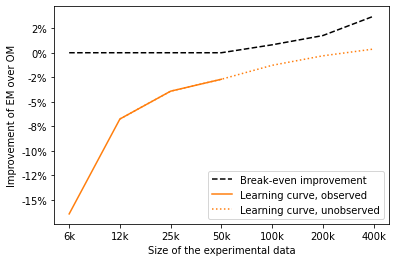

In [161]:
backup = pd.read_csv('learning_curve.csv')
improvements = backup['performance']
labels = backup['size']
plt.plot(labels, [0, 0, 0, 0] + breakevens, color='black', linestyle='dashed', label="Break-even improvement")
plt.plot(labels, improvements[:4].tolist() + [None, None, None], color='tab:orange', label="Learning curve, observed")
plt.plot(labels, [None] + improvements[1:].tolist(), color='tab:orange', linestyle='dotted', label="Learning curve, unobserved")
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.ylabel("Improvement of EM over OM")
plt.xlabel("Size of the experimental data")
plt.legend(loc='lower right')
plt.savefig("learning_curve.png", dpi=200, bbox_inches="tight")

# Confidence Intervals

In [27]:
visits = obs_df.groupby('treatment').visit.mean()
counts = obs_df.groupby('treatment').visit.count()
variances = obs_df.groupby('treatment').visit.var()
print(f"Naive confounded: {(visits[1] - visits[0])*100:.2f}%")
print(f"S.E.: {np.sqrt((variances/counts).sum())*100*1.96:.2f}%")
###################
visits = df.groupby('treatment').visit.mean()
counts = df.groupby('treatment').visit.count()
variances = df.groupby('treatment').visit.var()
print(f"Ground truth: {(visits[1] - visits[0])*100:.2f}%")
print(f"S.E.: {np.sqrt((variances/counts).sum())*100*1.96:.2f}%")

Naive confounded: 4.08%
S.E.: 0.03%
Ground truth: 1.03%
S.E.: 0.03%


Bootstrapping the experimental model.

In [22]:
from sklearn.utils import resample

bootstrap_size = 100
results = []
for i in range(bootstrap_size):
    print(i)
    data = resample(limited_exp, replace=True, random_state=i)
    tree = fit_tree(data, tune=False, min_samples_leaf=limited_tree.min_samples_leaf)
    result = tree.predict(data[limited_features]).mean()
    results.append(result)

0
--- Time to fit (and tune) causal tree 0.54060959815979 seconds ---
1
--- Time to fit (and tune) causal tree 0.5220036506652832 seconds ---
2
--- Time to fit (and tune) causal tree 0.5136191844940186 seconds ---
3
--- Time to fit (and tune) causal tree 0.5373034477233887 seconds ---
4
--- Time to fit (and tune) causal tree 0.4933624267578125 seconds ---
5
--- Time to fit (and tune) causal tree 0.5362660884857178 seconds ---
6
--- Time to fit (and tune) causal tree 0.4797847270965576 seconds ---
7
--- Time to fit (and tune) causal tree 0.5348711013793945 seconds ---
8
--- Time to fit (and tune) causal tree 0.5634500980377197 seconds ---
9
--- Time to fit (and tune) causal tree 0.6456456184387207 seconds ---
10
--- Time to fit (and tune) causal tree 0.5517866611480713 seconds ---
11
--- Time to fit (and tune) causal tree 0.5633797645568848 seconds ---
12
--- Time to fit (and tune) causal tree 0.5730924606323242 seconds ---
13
--- Time to fit (and tune) causal tree 0.5725953578948975 se

Unconfounded model: 1.37%
Unconfounded model (SE): 0.43%


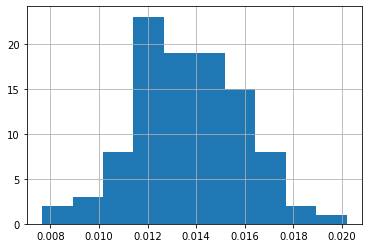

In [23]:
pd.Series(results).hist()
print(f"Unconfounded model: {np.mean(results)*100:.2f}%")
print(f"Unconfounded model (SE): {np.std(results)*100*1.96:.2f}%")

In [9]:
bootstrap_size = 10
results = []
for i in range(bootstrap_size):
    print(i)
    data = resample(obs_df, replace=True, random_state=i)
    #tree = fit_tree(data, tune=False, min_samples_leaf=obs_tree.min_samples_leaf)
    tree = fit_tree(data, tune=False, min_samples_leaf=32000)
    result = tree.predict(data[limited_features]).mean()
    results.append(result)

0
--- Time to fit (and tune) causal tree 208.7095718383789 seconds ---
1
--- Time to fit (and tune) causal tree 357.01459646224976 seconds ---
2
--- Time to fit (and tune) causal tree 353.66125321388245 seconds ---
3
--- Time to fit (and tune) causal tree 186.21985268592834 seconds ---
4
--- Time to fit (and tune) causal tree 196.14847135543823 seconds ---
5
--- Time to fit (and tune) causal tree 202.83232879638672 seconds ---
6
--- Time to fit (and tune) causal tree 190.43830251693726 seconds ---
7
--- Time to fit (and tune) causal tree 188.8630712032318 seconds ---
8
--- Time to fit (and tune) causal tree 197.38664031028748 seconds ---
9
--- Time to fit (and tune) causal tree 193.81672048568726 seconds ---


<AxesSubplot:>

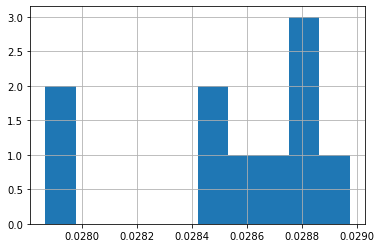

In [14]:
pd.Series(results).hist()

In [21]:
print(f"Confounded model: {pd.Series(results).mean()*100:.2f}%")
print(f"Confounded model S.E.: {pd.Series(results).std()*100*1.96:.2f}%")

Confounded model: 2.85%
Confounded model S.E.: 0.07%
